<a href="https://colab.research.google.com/github/HatemGamal/ElectroPi/blob/main/NLP_Twitter_Disaster_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#Importing all the neccessary libraries
import pandas as pd
import numpy as np #for linear algebra

#Libraries for visualisation
import matplotlib.pyplot as plt
import seaborn as sns

#Libraries for formattting and handling text
import string
import re


#Library for nltk
import nltk
import nltk.corpus
from nltk.corpus import stopwords

nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

stop=set(stopwords.words('english'))

#Library for NN
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant

#Library for Splitting Dataset
from sklearn.model_selection import train_test_split

#Library for TFIDF
from sklearn.feature_extraction.text import TfidfVectorizer

#Library for evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,classification_report

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
train_data = pd.read_csv('/content/train.csv')
test_data = pd.read_csv('/content/test.csv')

In [6]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
print('There are {} rows and {} columns in train'.format(train_data.shape[0],train_data.shape[1]))
print('There are {} rows and {} columns in train'.format(test_data.shape[0],test_data.shape[1]))

There are 7613 rows and 5 columns in train
There are 3263 rows and 4 columns in train


In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [9]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


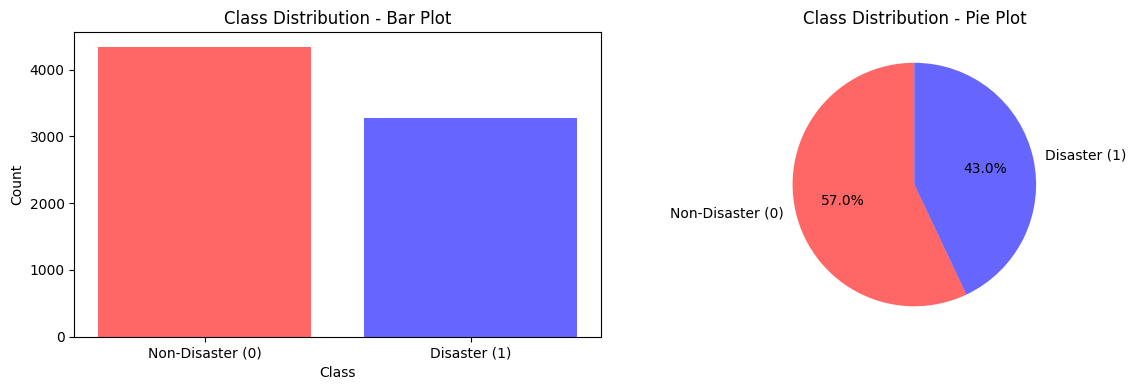

In [10]:
target_counts = train_data['target'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].bar(target_counts.index, target_counts.values, color=['red', 'blue'], alpha=0.6)
axes[0].set_xticks(target_counts.index)
axes[0].set_xticklabels(['Non-Disaster (0)', 'Disaster (1)'])
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
axes[0].set_title('Class Distribution - Bar Plot')

colors_with_alpha = [(1, 0, 0, 0.6), (0, 0, 1, 0.6)]
axes[1].pie(target_counts, labels=['Non-Disaster (0)', 'Disaster (1)'], colors=colors_with_alpha, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Class Distribution - Pie Plot')

plt.tight_layout()
plt.show()

# **Data Cleaning**

In [11]:
!pip install text_hammer
import text_hammer as th

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.8 MB/s eta 0:00:00
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.11.2
    Uninstalling beautifulsoup4-4.11.2:
      Successfully uninstalled beautifulsoup4-4.11.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yfinance 0.2.31 requires beautifulsoup4>=4.11.1, but you have beautifulsoup4 4.9.1 which is incompatible.


In [16]:
def text_cleaning(df,col_name):
    df[col_name] = df[col_name].progress_apply(lambda x:str(x).lower())
    df[col_name] = df[col_name].progress_apply(lambda x: th.remove_emails(x))
    df[col_name] = df[col_name].progress_apply(lambda x: th.remove_html_tags(x))
    df[col_name] = df[col_name].progress_apply(lambda x: th.remove_urls(x))
    df[col_name] = df[col_name].progress_apply(lambda x: th.remove_special_chars(x))
    df[col_name] = df[col_name].progress_apply(lambda x: th.remove_accented_chars(x))
    df[col_name] = df[col_name].progress_apply(lambda text: th.cont_exp(text))
    df[col_name] = df[col_name].progress_apply(lambda x: re.sub("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", "", x))
    df[col_name] = df[col_name].progress_apply(lambda x: re.sub(r'[^a-zA-Z]', ' ', x))
    df[col_name] = df[col_name].progress_apply(lambda x: ' '.join(x.split()))

    return(df)

In [17]:
train_data = text_cleaning(train_data,'text')
train_data.head()

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

In [19]:
test_data = text_cleaning(test_data,'text')
test_data.head()

  0%|          | 0/3263 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

,id,keyword,location,text
0,0,NaN,NaN,just happened a terrible car crash
1,2,NaN,NaN,heard about earthquake is different cities sta...
2,3,NaN,NaN,there is a forest fire at spot pond geese are ...
3,9,NaN,NaN,apocalypse lighting spokane wildfires
4,11,NaN,NaN,typhoon soudelor kills in china and taiwan


# **Remove Stop Words**

In [33]:
stop.remove('not')

KeyError: ignored

In [34]:
train_data['text'] = train_data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
test_data['text'] = test_data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,people receive wildfires evacuation orders cal...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1


# **Lemmatization**

In [35]:
def word_lemmatizer(text):
    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

In [37]:
train_data['text'] = train_data['text'].apply(lambda text: word_lemmatizer(text))
test_data['text'] = test_data['text'].apply(lambda text: word_lemmatizer(text))
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deed reason earthquake may allah forgive u,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,resident asked shelter place notified officer ...,1
3,6,NaN,NaN,people receive wildfire evacuation order calif...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfire pour...,1


In [38]:
import plotly.express as px

In [39]:
#Analysis for Non-Disaster Tweets
freqw=train_data[train_data['target']==0]['text'].str.split(expand=True).stack().value_counts()
freq100=freqw[:100]

fig=px.treemap(freq100,path=[freq100.index],values=0)
fig.update_traces(textinfo="label+value")
fig.update_layout(title={
        'text': "Non-Disaster Tweets",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

In [42]:
#Analysis for Disaster Tweets
freqw=train_data[train_data['target']==1]['text'].str.split(expand=True).stack().value_counts()
freq100=freqw[:100]

fig=px.treemap(freq100,path=[freq100.index],values=0)
fig.update_traces(textinfo="label+value")
fig.update_layout(title={
        'text': "Disaster Tweets",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()